In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import models, transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import argparse

In [2]:
model = models.resnet50(pretrained=True)
# get all the model children as list
model_children = list(model.children())

In [3]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


In [4]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [5]:
# input 이미지와 target 이미지 설정
input_image_list = ['livingroom_data/livingroom1.jpg','livingroom_data/livingroom2.jpg','livingroom_data/livingroom3.jpg','livingroom_data/livingroom4.jpg', 'livingroom_data/livingroom5.jpg']
target_image_list = ['art_data/art1.jpg', 'art_data/art2.jpg', 'art_data/art3.jpg', 'art_data/art4.jpg']

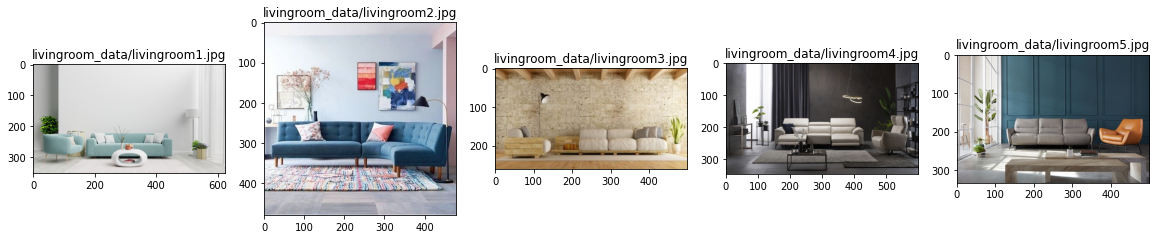

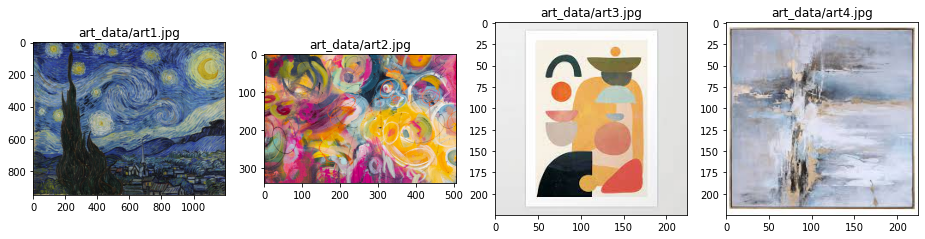

In [7]:
# read and visualize inputimages
plt.figure(figsize=(20, 4))
input_loaded_list = []
for i, input_image in enumerate(input_image_list):
    plt.subplot(1,5, i+1).set_title(input_image)
    img = cv.imread(input_image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    input_loaded_list.append(img)
plt.show()
# read and visualize target images

target_loaded_list = []
plt.figure(figsize=(20, 5))
for i, input_image in enumerate(target_image_list):
    plt.subplot(1,5, i+1).set_title(input_image)
    img = cv.imread(input_image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    target_loaded_list.append(img)
plt.show()

In [8]:
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

input_transformed_list = []
target_transformed_list = []
loaded_list = [input_loaded_list, target_loaded_list]

for i, loaded in enumerate(loaded_list):
    for cur_loaded in loaded:
        img = np.array(cur_loaded)
        # apply the transforms
        img = transform(img)
        # unsqueeze to add a batch dimension
        img = img.unsqueeze(0)
        if i == 0:
            input_transformed_list.append(img)
        else:
            target_transformed_list.append(img)
print(f"Length input_transformed_list : {len(input_transformed_list)}, length target_transformed_list : {len(target_transformed_list)}")
print(f"Final shape : {input_transformed_list[0].shape}")

Length input_transformed_list : 5, length target_transformed_list : 4
Final shape : torch.Size([1, 3, 512, 512])


In [9]:
# pass the image through all the layers
input_results_list = []
target_results_list = []
transformed_list = [input_transformed_list, target_transformed_list]
layer_list = []

for i, transformed in enumerate(transformed_list):
    for cur_transformed in transformed:
        temp_results = []
        results = [conv_layers[0](cur_transformed)]
        layer_list = []
        for j in range(1, len(conv_layers)):
            results.append(conv_layers[j](results[-1]))
            if j % 10 == 0 or j == len(conv_layers)-1:
                layer_list.append(f"layer {j}")
                temp_results.append(np.squeeze(results[-1], axis = 0))
        if i == 0:
            input_results_list.append(temp_results)
        else:
            target_results_list.append(temp_results)

print(f"num of input images : {len(input_results_list)}, num of result layer list of each images {len(input_results_list[0])}")
print(f"num of target images : {len(target_results_list)}, num of result layer list of each images {len(target_results_list[0])}")
print(f"shape of first layer : {target_results_list[0][0].shape}, shape of last layer: {target_results_list[0][-1].shape}")

num of input images : 5, num of result layer list of each images 5
num of target images : 4, num of result layer list of each images 5
shape of first layer : torch.Size([128, 256, 256]), shape of last layer: torch.Size([2048, 32, 32])


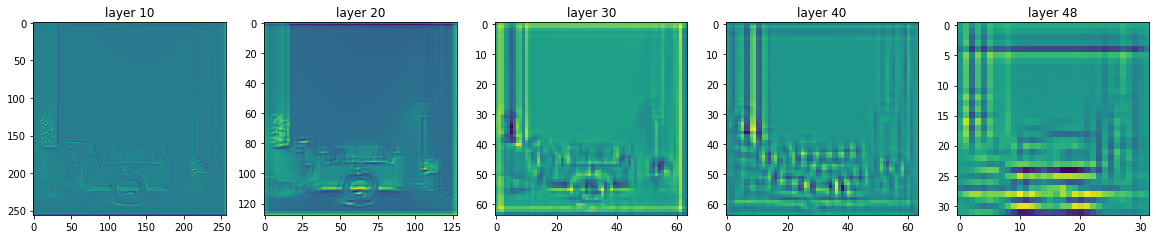

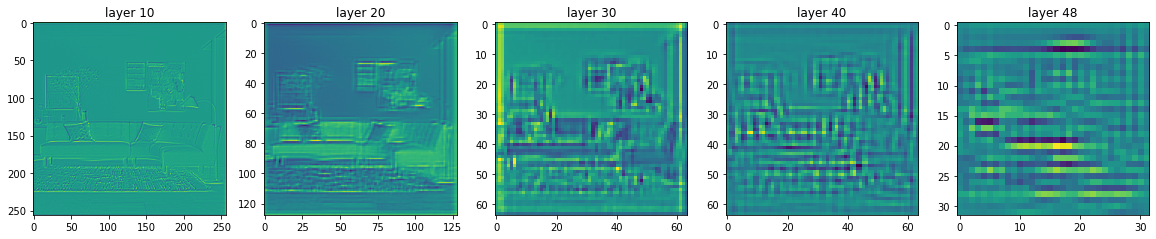

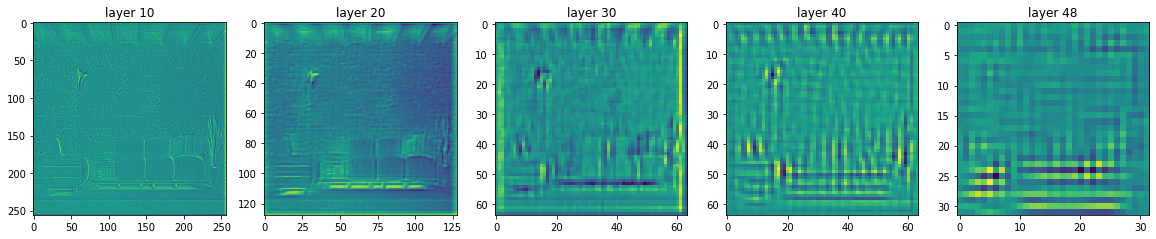

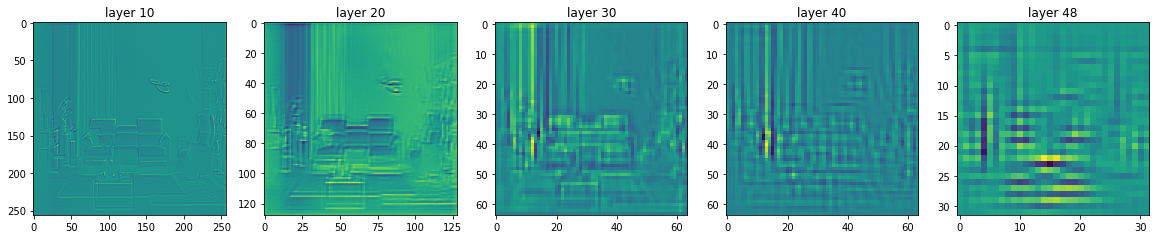

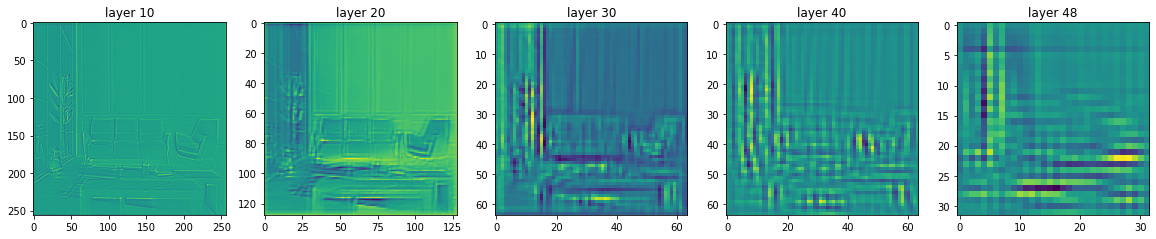

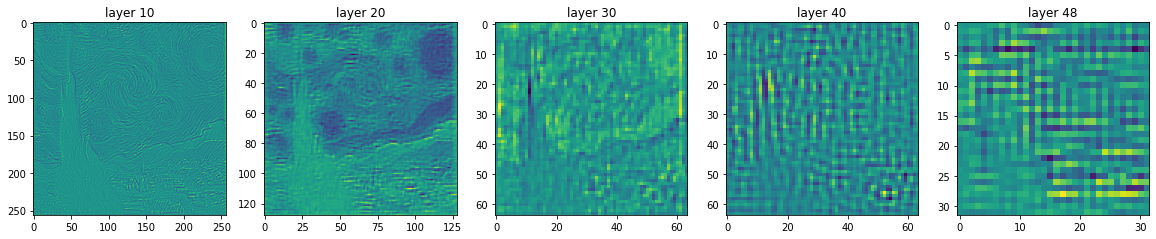

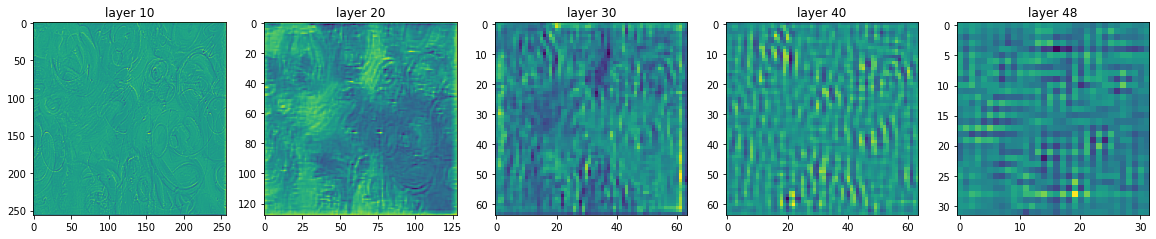

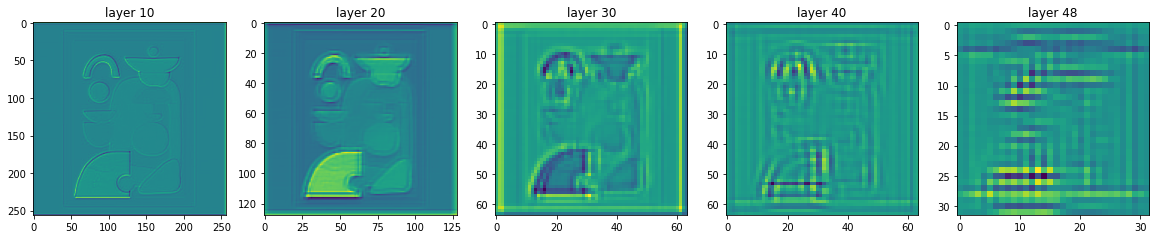

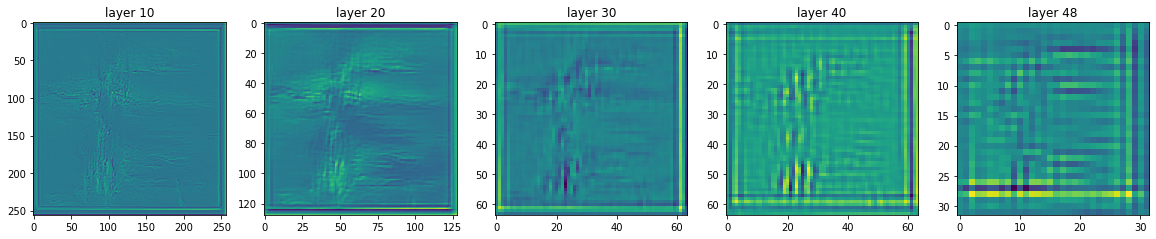

In [10]:
# visualize mean feature maps of 5 layers
final_results_list = [input_results_list, target_results_list]

for i, results_list in enumerate(final_results_list):
    for j, cur_image in enumerate(results_list):
        plt.figure(figsize=(20, 4))
        for k, cur_layer in enumerate(layer_list):
            plt.subplot(1,5, k+1).set_title(cur_layer)
            temp = torch.mean(cur_image[k], dim =0).detach().numpy()
            plt.imshow(temp)
        plt.show()

In [11]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [12]:
def calc_layer_similarity(input_result, target_results_list, cur_layer):
    input_result = torch.mean(input_result[cur_layer], dim =0).detach().numpy()
    similarity = []
#     loss = nn.MSELoss()
    for target_result in target_results_list:
        target_result = torch.mean(target_result[cur_layer], dim =0).detach().numpy()
#         similarity.append(loss(input_result, target_result))
        similarity.append(mse(input_result, target_result))
    return similarity

In [13]:
def min_max_normalize(lst):
    normalized = []
    
    for value in lst:
        normalized_num = (value - min(lst)) / (max(lst) - min(lst))
        normalized.append(normalized_num)
    
    return normalized

In [21]:
def get_resized_and_normalized_hist(input_loaded, target_loaded_list):
  input_loaded = cv.resize(input_loaded, dsize=(512, 512), interpolation=cv.INTER_AREA)
  input_hist = cv.calcHist([input_loaded], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
  input_hist = cv.normalize(input_hist, input_hist).flatten()

  target_hist_list = []
  for i, target_loaded in enumerate(target_loaded_list):
    target_loaded_list[i] = cv.resize(target_loaded_list[i], dsize=(512, 512), interpolation=cv.INTER_AREA)
    target_hist = cv.calcHist([target_loaded_list[i]], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    target_hist = cv.normalize(target_hist, target_hist).flatten()
    target_hist_list.append(target_hist)

  return input_hist, target_hist_list

In [19]:
# OPENCV_METHODS = (
#  ("Correlation", cv2.HISTCMP_CORREL),
#  ("Chi-Squared", cv2.HISTCMP_CHISQR),
#  ("Intersection", cv2.HISTCMP_INTERSECT),
#  ("Hellinger", cv2.HISTCMP_BHATTACHARYYA))

def calc_origin_similarity(input_loaded, target_loaded_list):
  similarity = []
  input_hist, target_hist_list = get_resized_and_normalized_hist(input_loaded, target_loaded_list)

  for i, hist in enumerate(target_hist_list):
    # compute the distance between the two histograms
    # using the method and update the results dictionary
    d = cv.compareHist(input_hist, hist, cv.HISTCMP_CORREL)
    similarity.append(d)
    
  return similarity


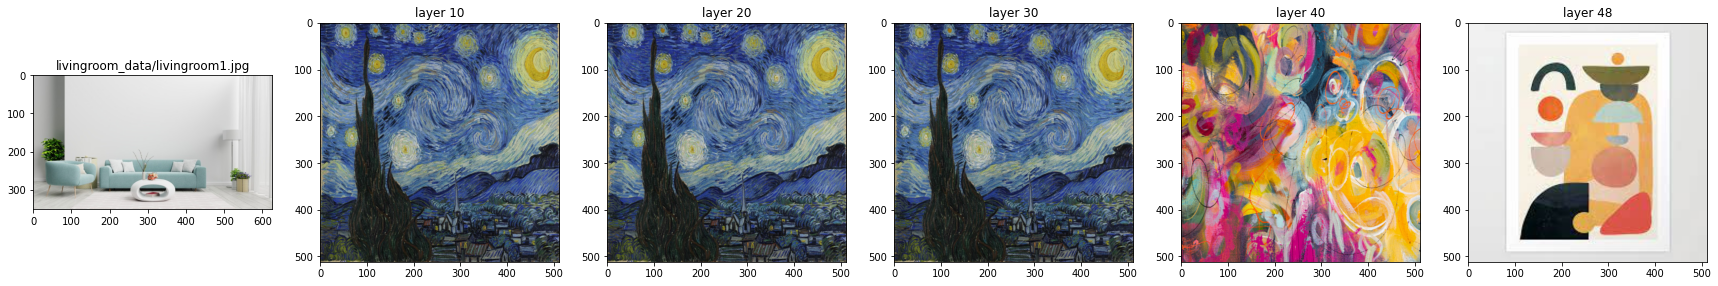

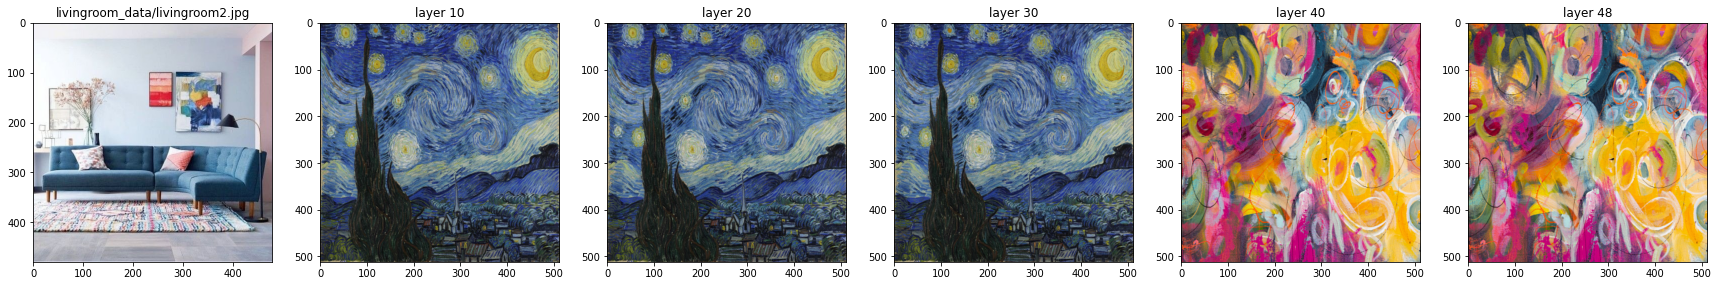

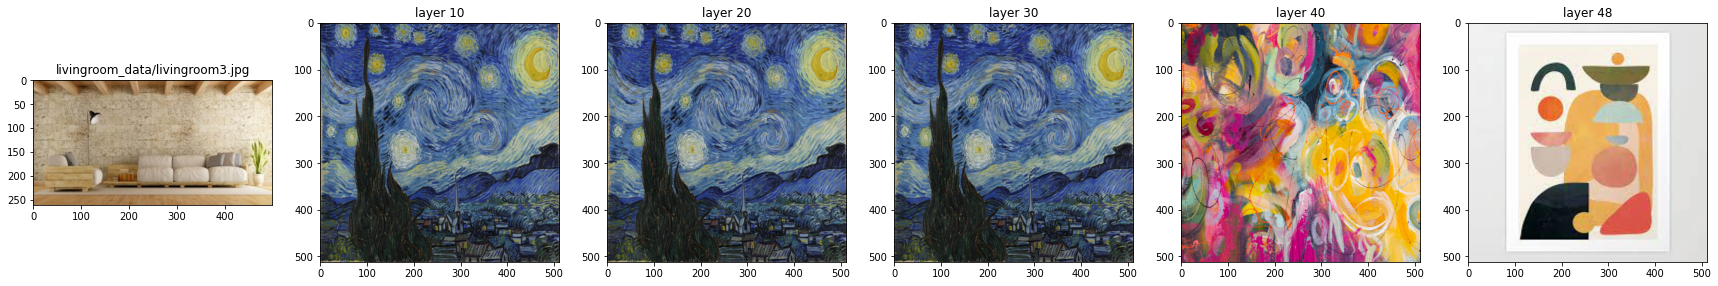

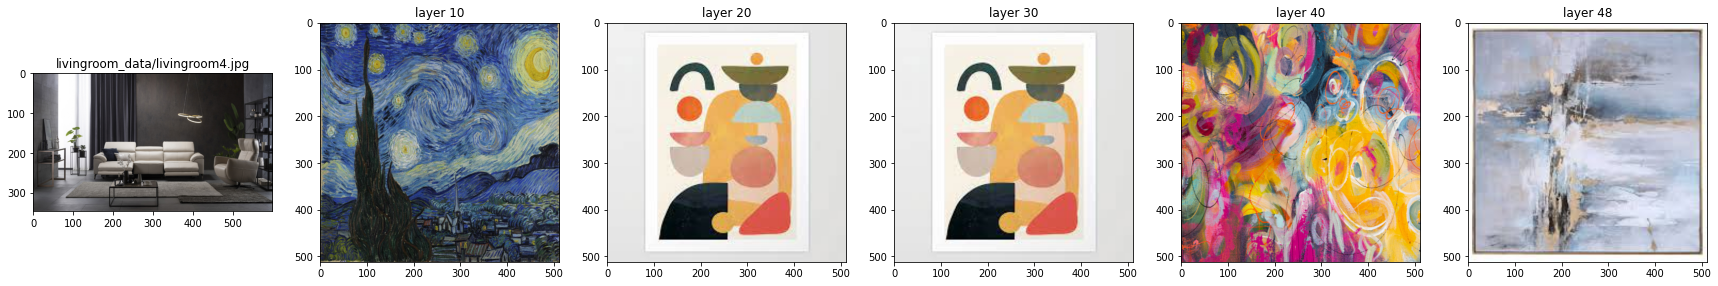

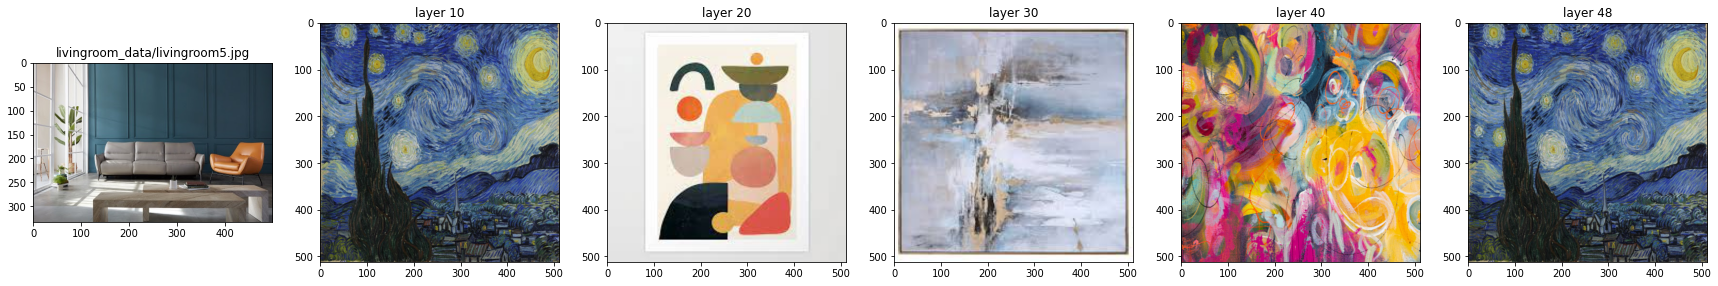

In [25]:
# compare layer by layer and choose the most similar image
for i, input_results in enumerate(input_results_list):
    plt.figure(figsize=(30, 5))
    plt.subplot(1,6, 1).set_title(input_image_list[i])
    plt.imshow(input_loaded_list[i])
    for t, cur_layer in enumerate(layer_list):
        plt.subplot(1,6, t+2).set_title(cur_layer)
        # 현재 input 과 전체 target 의 현재 layer 에서 유사도를 구한다. 
        layer_similarity_list = calc_layer_similarity(input_results, target_results_list, t)
        norm_layer_similarity_list = min_max_normalize(layer_similarity_list)
        # 현재 input 의 original 이미지와 target 의 original 이미지에서 calhist 를 한다.
        origin_similarity_list = calc_origin_similarity(input_loaded_list[i], target_loaded_list)
        norm_color_similarity_list = min_max_normalize(origin_similarity_list)
        # 패턴과 색조의 유사도에 wegith 를 주어 최종 similarity 를 구한다.
        pattern_weight = 4
        color_weight = 6
        final_similarity_list = pattern_weight * norm_layer_similarity_list + color_weight * norm_color_similarity_list

        index_of_similar_image_from_target = np.argmax(np.array(final_similarity_list))
        plt.imshow(target_loaded_list[index_of_similar_image_from_target])
    plt.show()

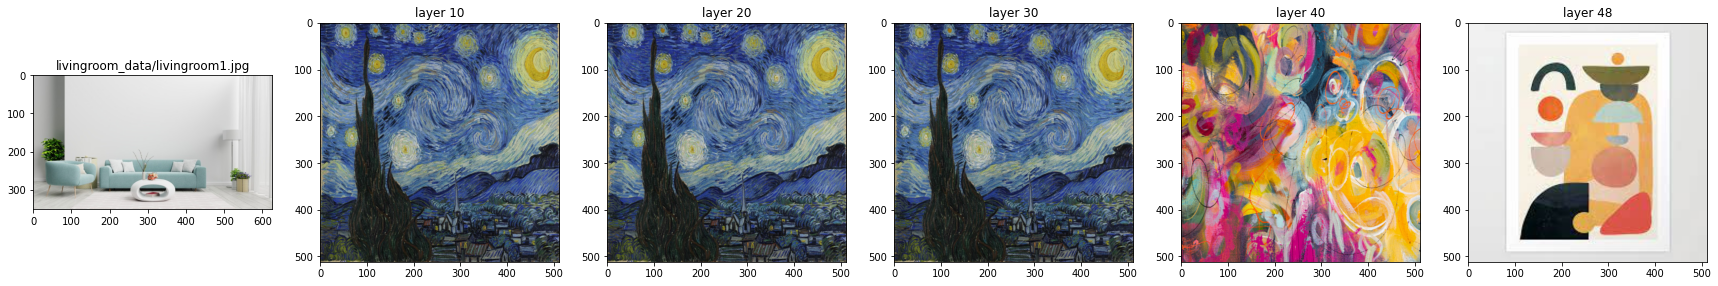

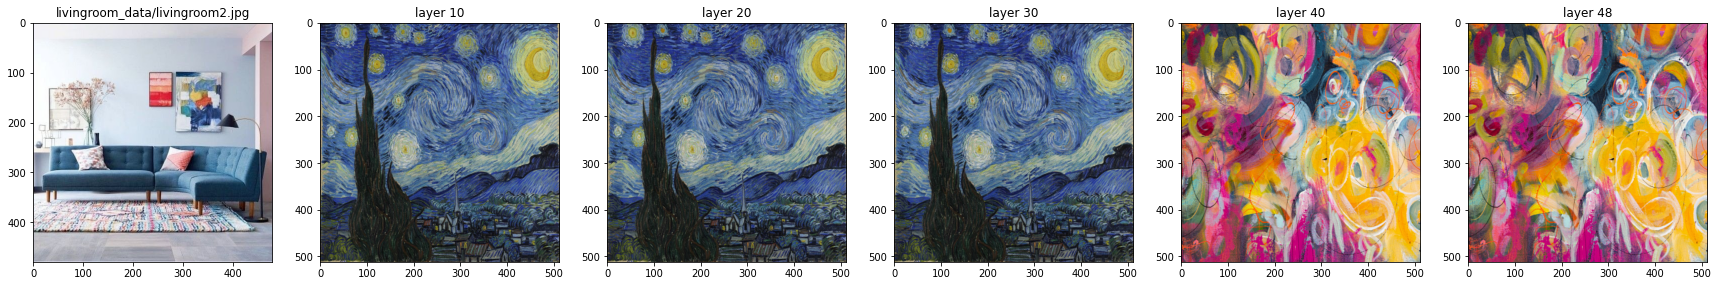

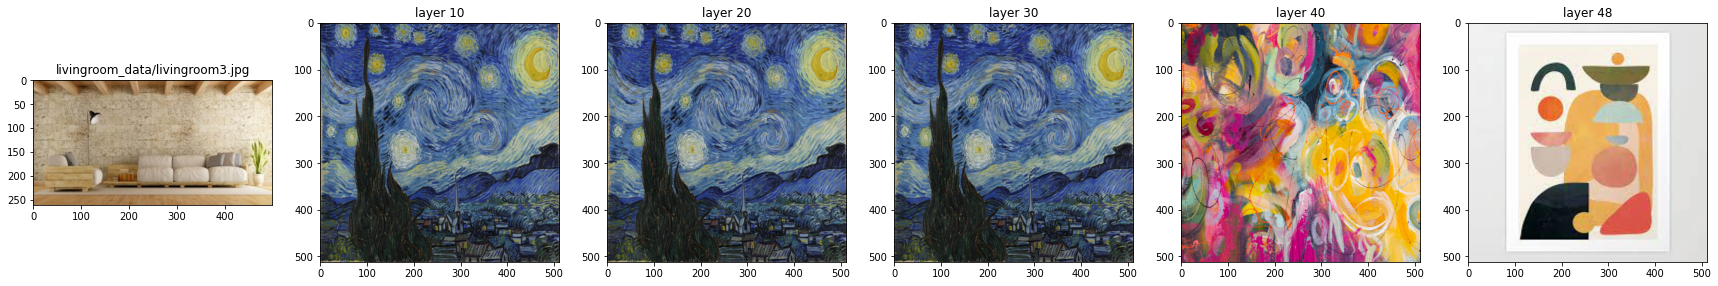

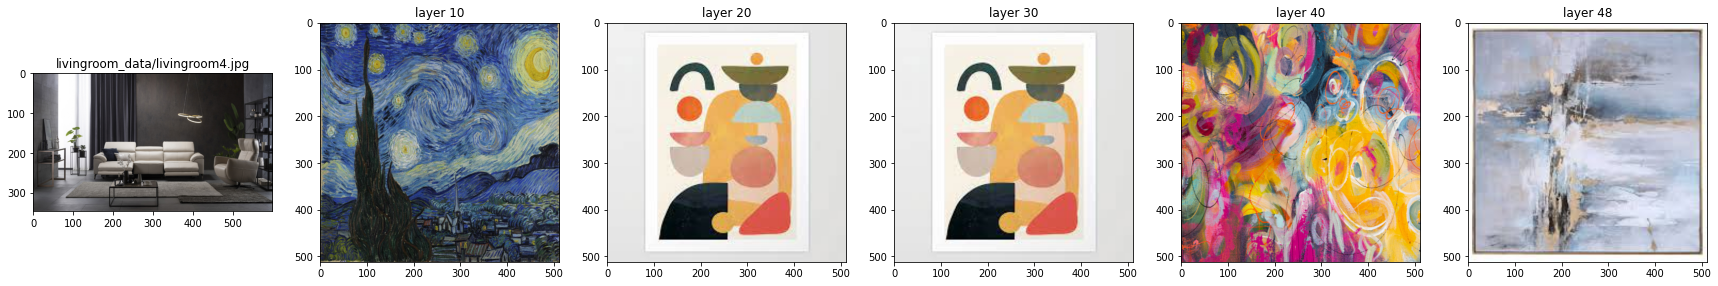

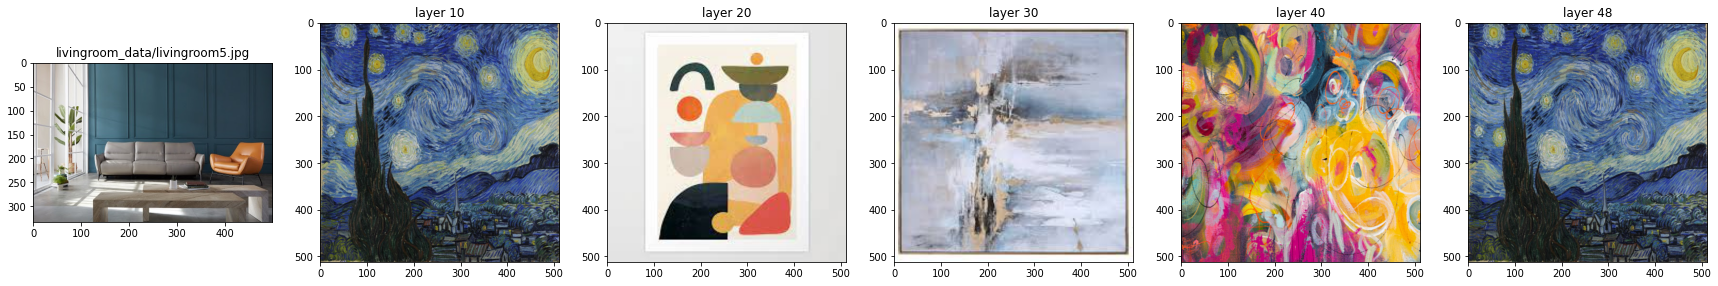

In [26]:
# compare layer by layer and choose the most similar image
for i, input_results in enumerate(input_results_list):
    plt.figure(figsize=(30, 5))
    plt.subplot(1,6, 1).set_title(input_image_list[i])
    plt.imshow(input_loaded_list[i])
    for t, cur_layer in enumerate(layer_list):
        plt.subplot(1,6, t+2).set_title(cur_layer)
        # 현재 input 과 전체 target 의 현재 layer 에서 유사도를 구한다. 
        layer_similarity_list = calc_layer_similarity(input_results, target_results_list, t)
        norm_layer_similarity_list = min_max_normalize(layer_similarity_list)
        # 현재 input 의 original 이미지와 target 의 original 이미지에서 calhist 를 한다.
        origin_similarity_list = calc_origin_similarity(input_loaded_list[i], target_loaded_list)
        norm_color_similarity_list = min_max_normalize(origin_similarity_list)
        # 패턴과 색조의 유사도에 wegith 를 주어 최종 similarity 를 구한다.
        pattern_weight = 10
        color_weight = 0
        final_similarity_list = pattern_weight * norm_layer_similarity_list + color_weight * norm_color_similarity_list

        index_of_similar_image_from_target = np.argmax(np.array(final_similarity_list))
        plt.imshow(target_loaded_list[index_of_similar_image_from_target])
    plt.show()

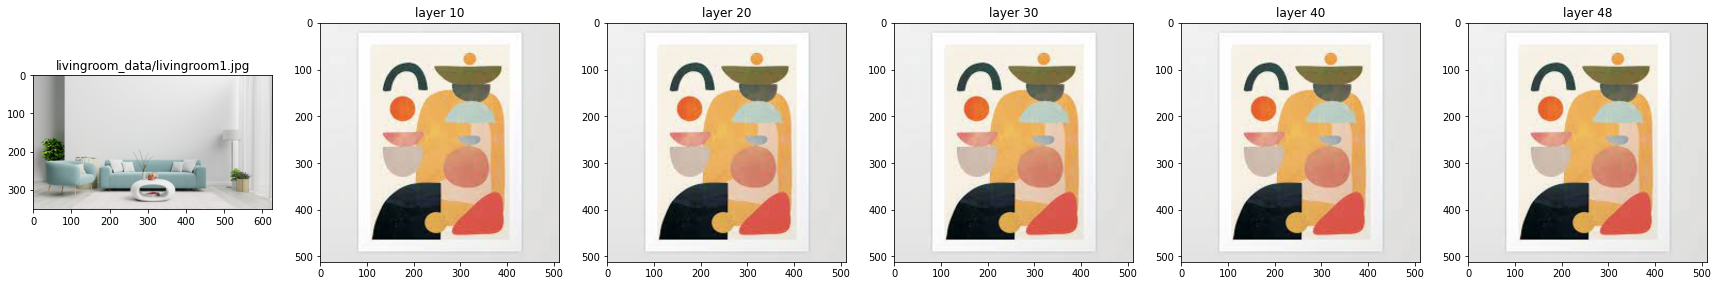

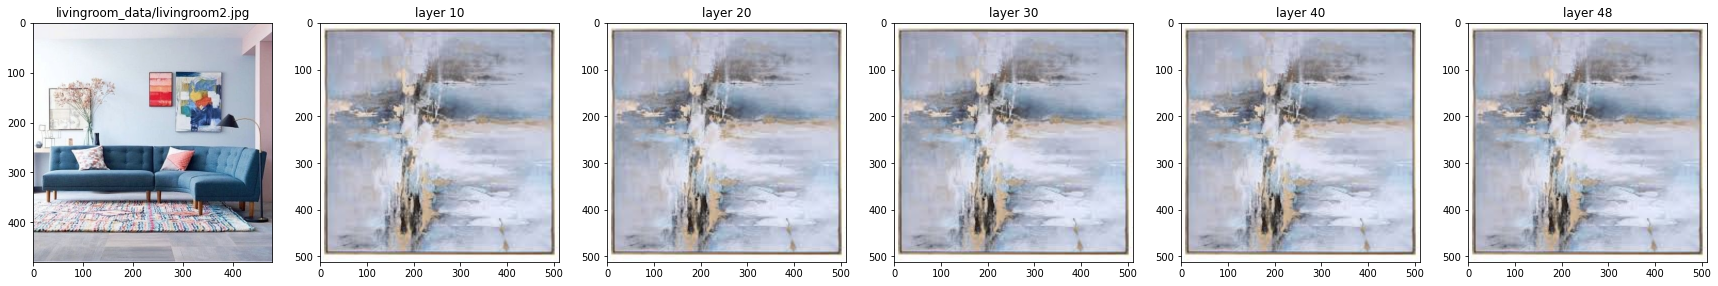

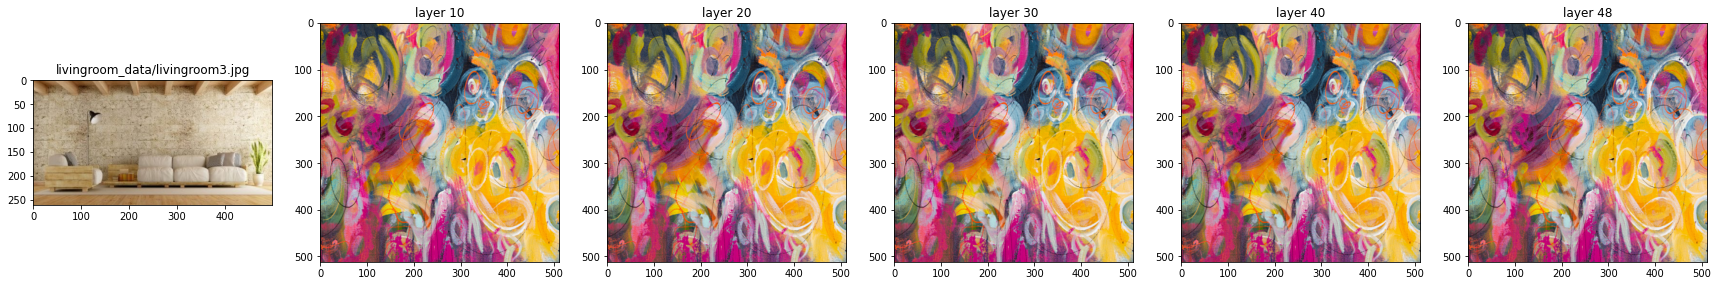

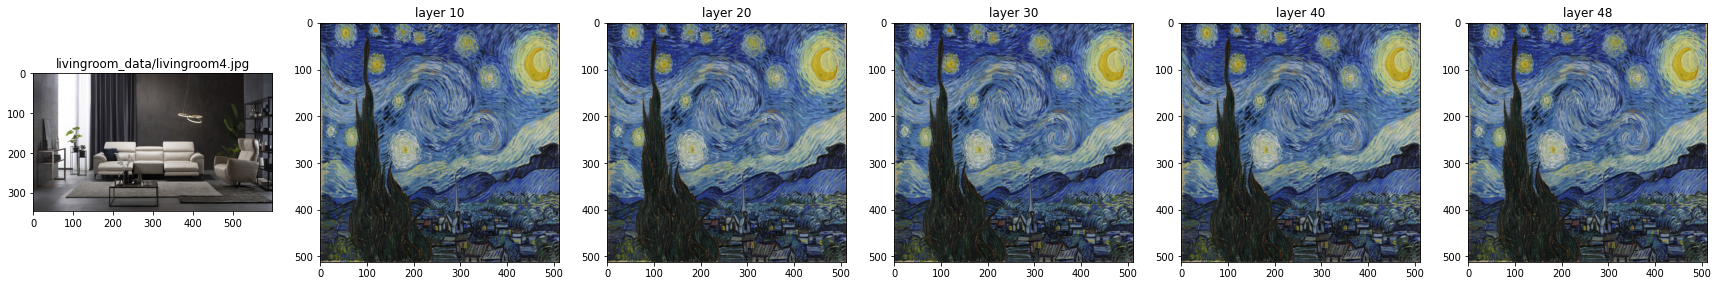

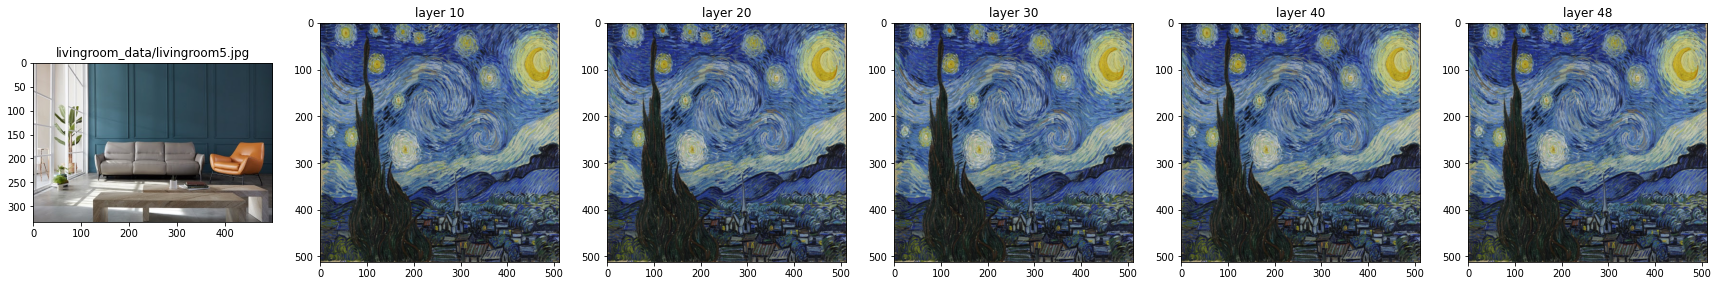

In [27]:
# compare layer by layer and choose the most similar image
for i, input_results in enumerate(input_results_list):
    plt.figure(figsize=(30, 5))
    plt.subplot(1,6, 1).set_title(input_image_list[i])
    plt.imshow(input_loaded_list[i])
    for t, cur_layer in enumerate(layer_list):
        plt.subplot(1,6, t+2).set_title(cur_layer)
        # 현재 input 과 전체 target 의 현재 layer 에서 유사도를 구한다. 
        layer_similarity_list = calc_layer_similarity(input_results, target_results_list, t)
        norm_layer_similarity_list = min_max_normalize(layer_similarity_list)
        # 현재 input 의 original 이미지와 target 의 original 이미지에서 calhist 를 한다.
        origin_similarity_list = calc_origin_similarity(input_loaded_list[i], target_loaded_list)
        norm_color_similarity_list = min_max_normalize(origin_similarity_list)
        # 패턴과 색조의 유사도에 wegith 를 주어 최종 similarity 를 구한다.
        pattern_weight = 0
        color_weight = 10
        final_similarity_list = pattern_weight * norm_layer_similarity_list + color_weight * norm_color_similarity_list

        index_of_similar_image_from_target = np.argmax(np.array(final_similarity_list))
        plt.imshow(target_loaded_list[index_of_similar_image_from_target])
    plt.show()